# Deep Learning Techniques for Speech Denoising and CIFAR-10 Classification with Transfer Learning

## Speech Denoising Using Deep Learning

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, ReLU

In [ ]:
s, sr = librosa.load('train_clean_male.wav', sr=None)
S = librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr = librosa.load('train_dirty_male.wav', sr=None)
X = librosa.stft(sn, n_fft=1024, hop_length=512)

# Take the magnitude of spectrograms
S_mag = np.abs(S)
X_mag = np.abs(X)

# Prepare training data
X_train = X_mag.T  # Shape: (2459, 513)
Y_train = S_mag.T  # Shape: (2459, 513)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_mag.T, S_mag.T, test_size=0.1, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(513,)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    tf.keras.layers.Dense(513, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform())  # Ensure nonnegative output
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,  # Set a high number of epochs; early stopping will terminate if needed
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1248 - val_loss: 0.0559
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0642 - val_loss: 0.0365
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352 - val_loss: 0.0267
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262 - val_loss: 0.0214
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0189
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - val_loss: 0.0171
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0136
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [ ]:
test_sn, _ = librosa.load('/content/test_x_01.wav', sr=None)
X_test = librosa.stft(test_sn, n_fft=1024, hop_length=512)
X_test_mag = np.abs(X_test).T

# Predict the clean magnitude spectrogram
S_test_mag_pred = model.predict(X_test_mag)

# Reconstruct the complex-valued spectrogram
S_test = (X_test / np.abs(X_test)) * S_test_mag_pred.T

# Apply inverse STFT to get the time-domain signal
s_test_reconstructed = librosa.istft(S_test, hop_length=512)

# Save the reconstructed audio
import soundfile as sf
sf.write('test_s_01_recons.wav', s_test_reconstructed, sr)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Load the ground-truth clean signal for SNR calculation
test_clean, _ = librosa.load('/content/test_s_01.wav', sr=None)

min_len = min(len(test_clean), len(s_test_reconstructed))
test_clean_trimmed = test_clean[:min_len]
s_test_reconstructed_trimmed = s_test_reconstructed[:min_len]

# Compute SNR
squared_diff = np.sum((test_clean_trimmed - s_test_reconstructed_trimmed) ** 2)
squared_signal = np.sum(test_clean_trimmed ** 2)
SNR = 10 * np.log10(squared_signal / (squared_diff + 1e-20))
print(f'SNR: {SNR} dB')

SNR: 8.448843355207424 dB


In [ ]:
test_sn_02, _ = librosa.load('/content/test_x_02.wav', sr=None)
X_test_02 = librosa.stft(test_sn_02, n_fft=1024, hop_length=512)
X_test_02_mag = np.abs(X_test_02).T

# Predict the clean magnitude spectrogram for test_02_x
S_test_02_mag_pred = model.predict(X_test_02_mag)

# Reconstruct the complex-valued spectrogram
S_test_02 = (X_test_02 / np.abs(X_test_02)) * S_test_02_mag_pred.T

# Apply inverse STFT to get the time-domain signal
s_test_02_reconstructed = librosa.istft(S_test_02, hop_length=512)

# Save the reconstructed audio for test_02_x
sf.write('test_s_02_recons.wav', s_test_02_reconstructed, sr)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


reconstructed sound of test_s_02
[test_s_02_reconstructed](https://drive.google.com/file/d/1zbpsJJaHTf7XRB6Jw_GnutT4XUti92do/view?usp=sharing)

## Speech Denoising Using 1D CNN


In [ ]:
#will start to load all the audio signals again to avoid mislap

In [ ]:
s, sr = librosa.load('train_clean_male.wav', sr=None)
S = librosa.stft(s, n_fft=1024, hop_length=512)

sn, sr = librosa.load('train_dirty_male.wav', sr=None)
X = librosa.stft(sn, n_fft=1024, hop_length=512)

# Take the magnitude of spectrograms
S_mag = np.abs(S)
X_mag = np.abs(X)

# Prepare training data
X_train = X_mag.T
Y_train = S_mag.T

In [ ]:
X_train = X_train[:, :, np.newaxis]
y_train = Y_train

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
model_CNN = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=(513,1), kernel_initializer=tf.keras.initializers.HeUniform()),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

    tf.keras.layers.Conv1D(filters=750, kernel_size=5, strides=2, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

    tf.keras.layers.Conv1D(filters=1024, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.HeUniform()),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(513, activation='relu')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mean_squared_error')

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=50,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,  # Set a high number of epochs; early stopping will terminate if needed
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0062
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0062
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [ ]:
test_sn, _ = librosa.load('/content/test_x_01.wav', sr=None)
X_test = librosa.stft(test_sn, n_fft=1024, hop_length=512)
X_test_mag = np.abs(X_test).T

# Predict the clean magnitude spectrogram
S_test_mag_pred = model.predict(X_test_mag)

# Reconstruct the complex-valued spectrogram
S_test = (X_test / np.abs(X_test)) * S_test_mag_pred.T

# Apply inverse STFT to get the time-domain signal
s_test_reconstructed = librosa.istft(S_test, hop_length=512)

# Save the reconstructed audio
import soundfile as sf
sf.write('test_s_01_recons_cnn.wav', s_test_reconstructed, sr)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
# Load the ground-truth clean signal for SNR calculation
test_clean, _ = librosa.load('/content/test_s_01.wav', sr=None)

#min_len = min(len(test_clean), len(s_test_reconstructed))
test_clean_trimmed = test_clean[:min_len]
s_test_reconstructed_trimmed = s_test_reconstructed[:min_len]

# Compute SNR
squared_diff = np.sum((test_clean_trimmed - s_test_reconstructed_trimmed) ** 2)
squared_signal = np.sum(test_clean_trimmed ** 2)
SNR = 10 * np.log10(squared_signal / (squared_diff + 1e-20))
print(f'SNR: {SNR} dB')

SNR: 11.247308227280179 dB


In [ ]:
test_sn_02, _ = librosa.load('/content/test_x_02.wav', sr=None)
X_test_02 = librosa.stft(test_sn_02, n_fft=1024, hop_length=512)
X_test_02_mag = np.abs(X_test_02).T

# Predict the clean magnitude spectrogram for test_02_x
S_test_02_mag_pred = model.predict(X_test_02_mag)

# Reconstruct the complex-valued spectrogram
S_test_02 = (X_test_02 / np.abs(X_test_02)) * S_test_02_mag_pred.T

# Apply inverse STFT to get the time-domain signal
s_test_02_reconstructed = librosa.istft(S_test_02, hop_length=512)

# Save the reconstructed audio for test_02_x
sf.write('test_s_02_recons_cnn.wav', s_test_02_reconstructed, sr)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Sound file of test_s_02
[test_s_02_recons_cnn](https://drive.google.com/file/d/1vBM5VRrzcu20bkqsVtf3oFXy_u3bxCPn/view?usp=sharing)

## Data Augmentation

In [ ]:
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000, random_state=42)

In [ ]:
X_train_base = X_train.astype('float32') / 255.0
X_val_base = X_val.astype('float32') / 255.0

In [ ]:
X_train = 2 * X_train_base - 1
X_val = 2 * X_val_base - 1

In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)

In [ ]:
X_train.shape

TensorShape([45000, 32, 32, 3])

In [ ]:
model_cifar = models.Sequential([
    layers.Conv2D(10, (5,5), strides=1,activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(10,(5,5),strides=1,activation='relu'),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cifar.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_cifar.fit(
    X_train, y_train,
    epochs=200,  # Set a high number of epochs; early stopping will terminate if needed
    batch_size=32,
    validation_data=(X_val, y_val),
)

Epoch 1/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3117 - loss: 1.8735 - val_accuracy: 0.4718 - val_loss: 1.4567
Epoch 2/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4882 - loss: 1.4054 - val_accuracy: 0.5046 - val_loss: 1.3529
Epoch 3/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5390 - loss: 1.2861 - val_accuracy: 0.5600 - val_loss: 1.2341
Epoch 4/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5703 - loss: 1.2021 - val_accuracy: 0.5590 - val_loss: 1.2089
Epoch 5/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5896 - loss: 1.1527 - val_accuracy: 0.5634 - val_loss: 1.2147
Epoch 6/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6030 - loss: 1.1207 - val_accuracy: 0.5966 - val_loss: 1.1222
Epoch 7/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6062 - loss: 1.1164 - val_accuracy: 0.5888 - val_loss: 1.1324
Epoch 8/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6258 - loss: 

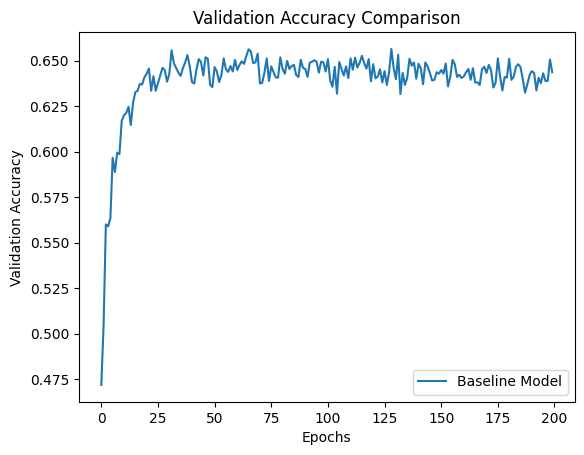

In [ ]:
plt.plot(history.history['val_accuracy'], label='Baseline Model')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Building Augmented classifier

In [ ]:
X_train_bright=np.minimum(1.1*X_train_base,1)
X_train_dark=np.maximum(0.9*X_train_base,0)
X_train_flip=np.flip(X_train_base,axis=2)

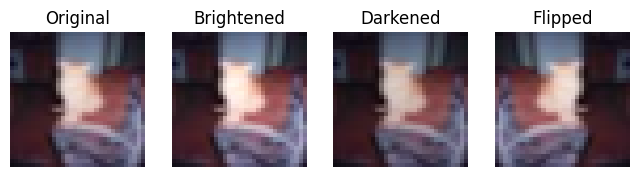

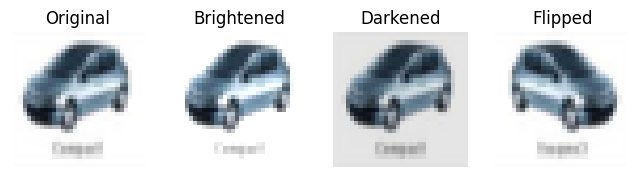

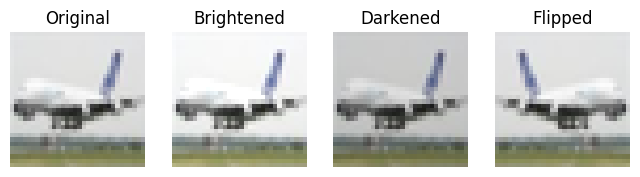

In [ ]:
for i in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(8, 8))

    # Original image
    axes[0].imshow(X_train_base[i])
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Brightened image
    axes[1].imshow(X_train_bright[i])
    axes[1].set_title('Brightened')
    axes[1].axis('off')

    # Darkened image
    axes[2].imshow(X_train_dark[i])
    axes[2].set_title('Darkened')
    axes[2].axis('off')

    # Flipped image
    axes[3].imshow(X_train_flip[i])
    axes[3].set_title('Flipped')
    axes[3].axis('off')

    plt.show()

In [ ]:
X_augmented = np.concatenate([X_train_base, X_train_bright, X_train_dark, X_train_flip], axis=0)
y_augmented = np.tile(y_train, (4, 1))

In [ ]:
#normalizing it to [-1,1] again.
X_augmented = 2 * X_augmented - 1
model_cifar.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_aug=model_cifar.fit(
    X_augmented, y_augmented,
    epochs=200,
    batch_size=32,validation_data=(X_val, y_val)
)

Epoch 1/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7063 - loss: 0.8481 - val_accuracy: 0.6520 - val_loss: 1.0551
Epoch 2/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7086 - loss: 0.8360 - val_accuracy: 0.6498 - val_loss: 1.0467
Epoch 3/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7102 - loss: 0.8353 - val_accuracy: 0.6528 - val_loss: 1.0535
Epoch 4/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7093 - loss: 0.8356 - val_accuracy: 0.6518 - val_loss: 1.0673
Epoch 5/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7099 - loss: 0.8341 - val_accuracy: 0.6584 - val_loss: 1.0106
Epoch 6/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7082 - loss: 0.8328 - val_accuracy: 0.6536 - val_loss: 1.0360
Epoch 7/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7126 - loss: 0.8271 - val_accuracy: 0.6586 - val_loss: 1.0063
Epoch 8/200
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7129 -

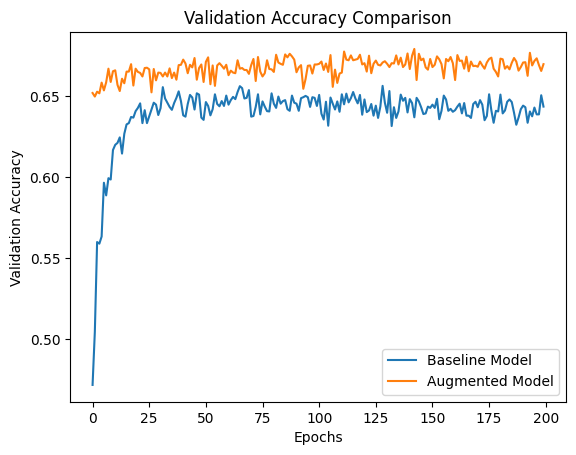

In [ ]:
plt.plot(history.history['val_accuracy'], label='Baseline Model')
plt.plot(history_aug.history['val_accuracy'], label='Augmented Model')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Self-Supervised Learning via Pretext Tasks

In [ ]:
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
(X_train_org, y_train_org), (X_test_org, y_test_org) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
X_train_label=X_train_org[49500::]
X_train=X_train_org[0:49500]
y_train_label=y_train_org[49500::]
y_train=y_train_org[0:49500]

In [ ]:
#X_train_org = X_train_org.astype('float32') / 255.0
X_train_label = X_train_label.astype('float32') / 255.0
X_test_org = X_test_org.astype('float32') / 255.0
X_train = X_train.astype('float32') / 255.0

In [ ]:
#Creating Class 0
X_train_class0=X_train
y_train_class0 = np.full((X_train.shape[0],),0, dtype=int)

In [ ]:
#create class 1
X_train_class1=np.flip(X_train, axis=1)
y_train_class1 = np.ones((X_train.shape[0],), dtype=int)

In [ ]:
#create class 2
X_train_class2=np.rot90(X_train, k=1, axes=(1, 2))
y_train_class2 = np.full((X_train.shape[0],), 2, dtype=int)

In [ ]:
#combine classes and labels
X_train_pretext=np.concatenate([X_train_class0,X_train_class1,X_train_class2],axis=0)
y_train_pretext=np.concatenate([y_train_class0,y_train_class1,y_train_class2],axis=0)

Building Pre_text model

In [ ]:
model_pretext = models.Sequential([
    layers.Conv2D(10, (5,5), strides=1,activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(10,(5,5),strides=1,activation='relu'),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [ ]:
model_pretext.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_pretext = model_pretext.fit(
    X_train_pretext, y_train_pretext,
    epochs=100,  # Set a high number of epochs; early stopping will terminate if needed
    batch_size=32,
)

Epoch 1/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6392 - loss: 0.7921
Epoch 2/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6697 - loss: 0.7410
Epoch 3/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6862 - loss: 0.7132
Epoch 4/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6960 - loss: 0.6961
Epoch 5/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7004 - loss: 0.6854
Epoch 6/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7038 - loss: 0.6759
Epoch 7/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7107 - loss: 0.6680
Epoch 8/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7111 - loss: 0.6588
Epoch 9/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7118 - loss: 0.6594
Epoch 10/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7161 - loss: 0.6520
Epoch 11/100
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7206 - loss: 0.6469
Epoch 12/100
4641/4

In [ ]:
model_pretext.save('cifar10_unlabble_trained_model.h5')

print("model saved cifar10_unlabble_trained_model.h5'")

model saved cifar10_unlabble_trained_model.h5'


In [ ]:
from tensorflow.keras.callbacks import Callback
class baseline(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    test_loss_arr=[]
    test_acc=[]
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Check every 100 epochs
            X_test, y_test = self.test_data
            test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
            self.test_loss_arr.append(test_loss)
            self.test_acc.append(test_accuracy)
            print(f"\nTest accuracy at epoch {epoch + 1}: {test_accuracy * 100:.2f}%")
test_data = (X_test_org, y_test_org)

In [ ]:
from tensorflow.keras.callbacks import Callback
class pretrained(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    test_loss_arr_1=[]
    test_acc_2=[]
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Check every 100 epochs
            X_test, y_test = self.test_data
            test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
            self.test_loss_arr_1.append(test_loss)
            self.test_acc_2.append(test_accuracy)
            print(f"\nTest accuracy at epoch {epoch + 1}: {test_accuracy * 100:.2f}%")

Building Base line model

In [ ]:
model_baseline = models.Sequential([
    layers.Conv2D(10, (5,5), strides=1,activation='relu', input_shape=(32, 32, 3), kernel_initializer=tf.keras.initializers.HeNormal()),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(10,(5,5),strides=1,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    layers.Dense(20, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()),
    layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.HeNormal())
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_line_hist=model_baseline.fit(X_train_label, y_train_label, epochs=10000,callbacks=[baseline(test_data)])

Streaming output truncated to the last 5000 lines.
Epoch 7526/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3345e-05 
Epoch 7527/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1203e-05 
Epoch 7528/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0632e-05 
Epoch 7529/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2347e-05 
Epoch 7530/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1885e-05 
Epoch 7531/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1109e-05 
Epoch 7532/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0214e-05 
Epoch 7533/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.3605e-06 
Epoch 7534/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1163e-05 
Epoch 7535/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2089e-05 

In [ ]:
model_baseline.save('cifar_baseline_trained_model.h5')
print("cifar_baseline_model_saved")

cifar_baseline_model_saved


In [ ]:
pretext_model = models.load_model('cifar10_unlabble_trained_model (2).h5')

Applying transfer learning and agjusting the learning rates

Process i followed for transfer learning is.
1. I have loaded the weights of pre text model into the new model architecture.
2. Then intialized freezed the traning layers of the new model by just keeping the classification layer actve. Now i trained the model on 1e-3 learning rate.
3. Later i have unfreezed all the layers and trained the model on 1e-5 learning rate.
This helps in adjusting the leanring rates while performing transfer learning.

I have also tried to develop a custom training function that could train various layers with customized learning rates.

In [ ]:
model_transfer_learning = models.Sequential([
    layers.Conv2D(10, (5,5), strides=1,activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(10,(5,5),strides=1,activation='relu'),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.HeNormal())
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
for layer_new, layer_pretext in zip(model_transfer_learning.layers[:-1], pretext_model.layers[:-1]):
    if layer_new.trainable and len(layer_new.get_weights()) > 0:
        layer_new.set_weights(layer_pretext.get_weights())

In [ ]:
for layer in model_transfer_learning.layers[:-1]:
    layer.trainable = False  # Unfreeze all layers in the pretext model

In [ ]:
model_transfer_learning.layers[-1].trainable = True

In [ ]:
# Step 4: Re-compile the pretext model with a low learning rate (1e-6)
from tensorflow.keras import optimizers
model_transfer_learning.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
Train_classfier=model_transfer_learning.fit(X_train_label, y_train_label, epochs=200,callbacks=[pretrained(test_data)])

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3681 - loss: 1.8172 
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3499 - loss: 1.8239 
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3806 - loss: 1.8034 
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3537 - loss: 1.7691 
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3821 - loss: 1.7050 
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3736 - loss: 1.7951 
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3585 - loss: 1.7439 
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3466 - loss: 1.8046 
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4068 - loss: 1.7190 
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3809 - loss: 1.7361 
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3612 - loss: 1.8426 
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [ ]:
from tensorflow.keras import optimizers
model_transfer_learning.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
for layer in model_transfer_learning.layers[:-1]:
    layer.trainable = True

In [ ]:
model_transfer_learning.layers[-1].trainable=True

In [ ]:
Train_complete_model=model_transfer_learning.fit(X_train_label, y_train_label, epochs=10000,callbacks=[pretrained(test_data)])

Streaming output truncated to the last 5000 lines.
Epoch 7526/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.1146e-04 
Epoch 7527/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.0554e-04 
Epoch 7528/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.7431e-04 
Epoch 7529/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7925e-04 
Epoch 7530/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.5752e-04 
Epoch 7531/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.5542e-04 
Epoch 7532/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.9792e-04 
Epoch 7533/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7105e-04 
Epoch 7534/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.3289e-04 
Epoch 7535/10000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.6533e-04 

In [ ]:
model_transfer_learning.save('new_model_transfer_learning.h5')

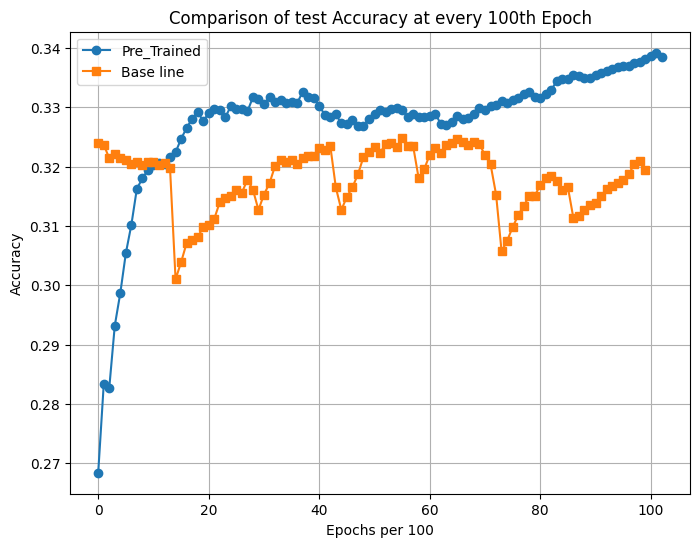

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual arrays
array1=pretrained.test_acc_2
array2=baseline.test_acc

# Plot both arrays
plt.figure(figsize=(8, 6))
plt.plot(array1, label='Pre_Trained', marker='o')
plt.plot(array2, label='Base line', marker='s')

# Add labels and title
plt.xlabel('Epochs per 100')
plt.ylabel('Accuracy')
plt.title('Comparison of test Accuracy at every 100th Epoch')

# Add grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


So, ulimately the transfer learning model is performing better that the base line model. Using the weights of the pre text model effects the models featuer understanding ability postively. Hence results in better classfication.

Other method to execute Transfer learning using custom traning function. (Just a try)

In [ ]:
model_transfer_learning_cust = models.Sequential([
    layers.Conv2D(10, (5,5), strides=1,activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(10,(5,5),strides=1,activation='relu'),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='softmax',kernel_initializer=tf.keras.initializers.HeNormal())
])

In [ ]:
for layer_new, layer_pretext in zip(model_transfer_learning_cust.layers[:-1], pretext_model.layers[:-1]):
    if layer_new.trainable and len(layer_new.get_weights()) > 0:
        layer_new.set_weights(layer_pretext.get_weights())

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [ ]:
# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrics to track training and test accuracy
train_accuracy_metric = SparseCategoricalAccuracy()
test_accuracy_metric = SparseCategoricalAccuracy()

optimizer_slow = tf.keras.optimizers.Adam(learning_rate=0.00001)  # For initial layers
optimizer_fast = tf.keras.optimizers.Adam(learning_rate=0.001)    # For the last layer

In [ ]:
# Define batch size
batch_size = 50  # Manually set the batch size
num_batches = 500// batch_size

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape(persistent=True) as tape:
        predictions = model_transfer_learning_cust(images, training=True)
        loss = loss_fn(labels, predictions)

    # Get the trainable variables for different parts of the model
    slow_layers = model_transfer_learning_cust.layers[:-1]  # All layers except the last one
    fast_layers = [model_transfer_learning_cust.layers[-1]]  # Last layer

    slow_trainable_vars = []
    for layer in slow_layers:
        slow_trainable_vars.extend(layer.trainable_variables)

    fast_trainable_vars = fast_layers[0].trainable_variables

    # Compute gradients
    slow_gradients = tape.gradient(loss, slow_trainable_vars)
    fast_gradients = tape.gradient(loss, fast_trainable_vars)

    # Apply gradients to different optimizers
    optimizer_slow.apply_gradients(zip(slow_gradients, slow_trainable_vars))
    optimizer_fast.apply_gradients(zip(fast_gradients, fast_trainable_vars))

    # Update the training accuracy
    train_accuracy_metric.update_state(labels, predictions)

    # Clean up the tape
    del tape

    return loss


In [ ]:
# Test step to calculate accuracy on test data
@tf.function
def test_step(images, labels):
    predictions = model_transfer_learning_cust(images, training=False)
    test_accuracy_metric.update_state(labels, predictions)

In [ ]:
train_data = X_train_label
train_labels = y_train_label
test_data = X_test_org
test_labels = y_test_org

In [ ]:
epochs = 10000
test_acc_st=[]
for epoch in range(epochs):
    # Reset training accuracy for every epoch
    train_accuracy_metric.reset_state()

    # Shuffle the data at the beginning of each epoch
    indices = tf.random.shuffle(tf.range(len(X_train_label)))
    train_data = tf.gather(train_data, indices)
    train_labels = tf.gather(train_labels, indices)

    # Loop over the data in batches
    for batch in range(num_batches):
        batch_data = train_data[batch * batch_size:(batch + 1) * batch_size]
        batch_labels = train_labels[batch * batch_size:(batch + 1) * batch_size]

        # Perform one training step on the batch
        loss = train_step(batch_data, batch_labels)

    # Print training loss and accuracy for each epoch
    train_accuracy = train_accuracy_metric.result().numpy()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}, Train Accuracy: {train_accuracy}")

    # Every 100 epochs, evaluate and print test accuracy

    if (epoch + 1) % 100 == 0:

        test_accuracy_metric.reset_state()
        test_step(test_data, test_labels)
        test_accuracy = test_accuracy_metric.result().numpy()
        test_acc_st.append(test_accuracy)
        print(f"Test Accuracy at epoch {epoch+1}: {test_accuracy}")

Streaming output truncated to the last 5000 lines.
Epoch 5051/10000, Loss: 0.013891147449612617, Train Accuracy: 0.9879999756813049
Epoch 5052/10000, Loss: 0.013993852771818638, Train Accuracy: 0.9919999837875366
Epoch 5053/10000, Loss: 0.013884883373975754, Train Accuracy: 0.9919999837875366
Epoch 5054/10000, Loss: 2.932544873601728e-07, Train Accuracy: 0.9940000176429749
Epoch 5055/10000, Loss: 0.013919132761657238, Train Accuracy: 0.9940000176429749
Epoch 5056/10000, Loss: 0.013896758668124676, Train Accuracy: 0.9940000176429749
Epoch 5057/10000, Loss: 0.013891726732254028, Train Accuracy: 0.9940000176429749
Epoch 5058/10000, Loss: 1.0394926448498154e-06, Train Accuracy: 0.9919999837875366
Epoch 5059/10000, Loss: 8.249205620813882e-07, Train Accuracy: 0.9900000095367432
Epoch 5060/10000, Loss: 4.408238055475522e-06, Train Accuracy: 0.9940000176429749
Epoch 5061/10000, Loss: 8.985702879726887e-05, Train Accuracy: 0.9940000176429749
Epoch 5062/10000, Loss: 0.05552287772297859, Train A

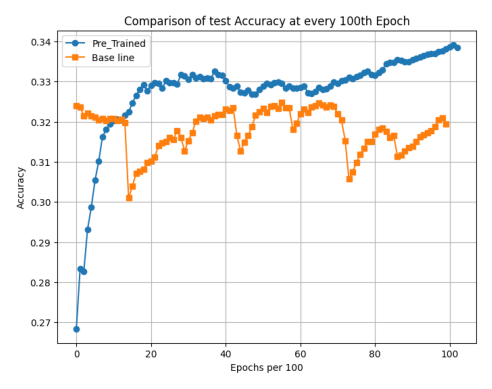

In [64]:
import matplotlib.pyplot as plt

# Replace these with your actual arrays
array1=test_acc_st
array2=baseline.test_acc

# Plot both arrays
plt.figure(figsize=(6, 6))
plt.plot(array1, label='Pre_Trained', marker='o')
plt.plot(array2, label='Base line', marker='s')

# Add labels and title
plt.xlabel('Epochs per 100')
plt.ylabel('Accuracy')
plt.title('Comparison of test Accuracy at every 100th Epoch')

# Add grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

The above grpah shows that the pre-trained performes well compared to the baseline. which is similar while we implmeneted the direct training approach.